# Final Project

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import datetime


#SK-learn libraries for setup
from sklearn.model_selection import train_test_split

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

#SK-learn libraries for transformation and pre-processing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer



# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer


/Users/nwchen24/anaconda/envs/Machine_learning_python2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/nwchen24/anaconda/envs/Machine_learning_python2/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [223]:
#Read data
os.chdir("/Users/nwchen24/Desktop/UC_Berkeley/machine_learning/final_project_github_repo/w207_kaggleproject/data/")

#training data
train_data_full = pd.read_csv('train.csv')
train_data_full.head()

#testing data
test_data = pd.read_csv('test.csv')

In [224]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

## Prep

In [225]:
#Create a program age variable
#Do this before we do the train test split because the beginning of the program is a constant, so we don't
#have to worry about 'contaminating' any of our data by applying the same transformation to the entire dataset

#Convert to datetime object
train_data_full['datetime'] = train_data_full['datetime'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
test_data['datetime'] = test_data['datetime'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

#Initialized program beginning
prog_beginning = '2011-01-01 00:00:00'

prog_beginning_conv = datetime.strptime(prog_beginning, '%Y-%m-%d %H:%M:%S')

#Create a program age variable
train_data_full['prog_age'] = train_data_full['datetime'] - prog_beginning_conv
test_data['prog_age'] = test_data['datetime'] - prog_beginning_conv


#convert the time delta to float of days
train_data_full['prog_age'] = train_data_full['prog_age'].dt.total_seconds() / (24 * 60 * 60)
test_data['prog_age'] = test_data['prog_age'].dt.total_seconds() / (24 * 60 * 60)


#create an hour variable in both the training and development data
train_data_full['hour'] = train_data_full.datetime.apply(lambda x : x.hour)
test_data['hour'] = test_data.datetime.apply(lambda x : x.hour)

In [226]:
#Split into train and development
train_data, dev_data = train_test_split(train_data_full, random_state = 0)

In [227]:
print test_data.datetime.dtype
print train_data_full.datetime.dtype
test_data.tail()

datetime64[ns]
datetime64[ns]


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,prog_age,hour
6488,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,730.791667,19
6489,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,730.833333,20
6490,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,730.875000,21
6491,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,730.916667,22
6492,2012-12-31 23:00:00,1,0,1,1,10.66,13.635,65,8.9981,730.958333,23


In [228]:
#Add a string desctriptor for weather
weather_values = [1,2,3,4]
weather_descriptions = ['Nice Weather', 'OK Weather', 'Poor Weather', 'Bad Weather']
weather_dict_df = pd.DataFrame({'weather' : weather_values, 'weather_descriptions': weather_descriptions})

weather_dict_df
train_data = pd.merge(train_data, weather_dict_df, how = 'left')

#Add a string descriptor for season
season_values = [1,2,3,4]
season_str = ['Spring', 'Summer', 'Fall', 'Winter']
season_dict_df = pd.DataFrame({'season' : season_values, 'season_str': season_str})

train_data = pd.merge(train_data, season_dict_df, how = 'left')

train_data.head()

train_data.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,prog_age,hour
count,8164.000000,8164.000000,8164.000000,8164.00000,8164.000000,8164.000000,8164.000000,8164.000000,8164.000000,8164.000000,8164.000000,8164.000000,8164.000000
mean,2.496570,0.029030,0.679936,1.41389,20.137509,23.551758,61.836722,12.832602,35.762371,154.923199,190.685571,359.423643,11.554998
std,1.118645,0.167901,0.466529,0.63025,7.776977,8.463277,19.239196,8.262360,49.826465,151.318558,181.191213,211.072559,6.929567
min,1.000000,0.000000,0.000000,1.00000,0.820000,2.275000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,1.00000,13.940000,16.665000,47.000000,7.001500,4.000000,36.000000,43.000000,181.072917,6.000000
50%,2.000000,0.000000,1.000000,1.00000,20.500000,24.240000,62.000000,12.998000,16.000000,116.000000,142.000000,365.854167,12.000000
75%,3.000000,0.000000,1.000000,2.00000,26.240000,31.060000,77.000000,16.997900,48.000000,223.000000,284.000000,535.635417,18.000000
max,4.000000,1.000000,1.000000,4.00000,41.000000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000,718.916667,23.000000


In [229]:
train_data.hour.dtype

dtype('int64')

In [230]:
#Helper function to calculate root mean squared error
def get_RMSE(actual_values, predicted_values):
    n = len(actual_values)
    RMSE = np.sqrt(np.sum(((np.log(predicted_values + 1) - np.log(actual_values + 1)) ** 2) / n))
    return RMSE

    

## Feature Engineering / Preprocessing

In [231]:
#Create lists of categorical and numeric predictors
categorical_predictors = ['season', 'holiday', 'workingday', 'hour']
numerical_predictors = ['temp', 'atemp', 'humidity', 'windspeed', 'prog_age']

In [232]:
#Categorical variable imputer
class CategoricalImputer(BaseEstimator, TransformerMixin):
    
    def __init__(self, cols):
        self.cols = cols
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        transformed_df = X
        for col in self.cols:
            transformed_df.loc[:, col] = transformed_df.loc[:, col].astype(str)
        return transformed_df
       

In [233]:
#One-hot / hashing for categorical features
from sklearn.feature_extraction import FeatureHasher, DictVectorizer

class MyVectorizer(BaseEstimator, TransformerMixin):
    """
    Vectorize a set of categorical variables
    """
    
    def __init__(self, cols, hashing=None):
        """
        args:
            cols: a list of column names of the categorical variables
            hashing: 
                If None, then vectorization is a simple one-hot-encoding.
                If an integer, then hashing is the number of features in the output.
        """
        self.cols = cols
        self.hashing = hashing
        
    def fit(self, X, y=None):      
        #define the data
        data = X[self.cols]
        
        #select a vectorizer based on the hashing argument
        if self.hashing == None:
            self.myvec = DictVectorizer(sparse=False)
        else:
            self.myvec = FeatureHasher(n_features=self.hashing)
        
        #fit the vectorizer chosen based on columns specified
        self.myvec.fit(X[self.cols].to_dict(orient='records'))
        return self
            
    def transform(self, X):
        # Vectorize Input
        if self.hashing is None:
            return pd.DataFrame(
                self.myvec.transform(X[self.cols].to_dict(orient='records')),
                columns = self.myvec.feature_names_
            )
        else:
            return pd.DataFrame(
                self.myvec.transform(X[self.cols].to_dict(orient='records')).toarray()
            )
   

In [234]:
#Numerical variable imputer
class MyNumericImputer(BaseEstimator, TransformerMixin):
    
    def __init__(self, cols, strategy = 'mean'):
        self.cols = cols
        self.strategy = strategy

    def fit(self, X, y=None):       
        self.imputer = Imputer(strategy = self.strategy)
        self.imputer.fit(X[self.cols])
        return self
    
    def transform(self, X):
        return pd.DataFrame(self.imputer.transform(X[self.cols]), columns = self.cols)
        #return self.imputer.transform(X[self.cols])


In [235]:
#Numeical variable scaler
class MyScaler(BaseEstimator, TransformerMixin):
    
    def __init__(self, cols):
        self.cols = cols
        
    def fit(self, X, y=None):
        self.scaler = StandardScaler()
        self.scaler.fit(X[self.cols])
        return self
    
    def transform(self, X):
        return pd.DataFrame(self.scaler.transform(X[self.cols]), columns = self.cols)

In [236]:
#Categorical pipeline

#instantiate imputer and vectorizer for categorical pipe
imp_for_pipe = CategoricalImputer(categorical_predictors)
vect_for_pipe = MyVectorizer(cols = categorical_predictors, hashing = None)



#construct pipeline
categorical_pipe = Pipeline([
        ('to_string', imp_for_pipe),
        ('vectorize', vect_for_pipe)
    ])

In [237]:
#test categorical pipeline
transformed_train = categorical_pipe.fit_transform(train_data)

transformed_train.head()

,holiday=0,holiday=1,hour=0,hour=1,hour=10,hour=11,hour=12,hour=13,hour=14,hour=15,...,hour=6,hour=7,hour=8,hour=9,season=1,season=2,season=3,season=4,workingday=0,workingday=1
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [238]:
train_data.hour.dtype

dtype('O')

In [239]:
#Numerical variables pipeline

#instantiate imputer for pipeline
mynumimp = MyNumericImputer(cols = numerical_predictors, strategy = 'mean')
#instantiate scaler for pipeline
scaler = MyScaler(cols = numerical_predictors)

#construct pipeline
numerical_pipe = Pipeline([
        ('impute', mynumimp),
        ('scale', scaler)
    ])

In [240]:
#test numerical pipeline
transformed_train_2 = numerical_pipe.fit_transform(train_data)

transformed_train_2.head()

,temp,atemp,humidity,windspeed,prog_age
0,-0.691508,-0.723967,1.619880,-0.464121,1.654910
1,1.101073,1.066229,0.164428,-1.553235,-0.902227
2,0.257505,0.260936,-1.291023,1.351609,0.646111
3,-0.164278,-0.097694,1.671860,0.020020,-0.095188
4,-0.586062,-0.455733,-0.823199,1.594085,-1.199141


In [241]:
#transform both the categorical and numeric features using FeatureUnion
fu = FeatureUnion([
        ('numerical', numerical_pipe),
        ('categorical', categorical_pipe)
    ])


#Training data
X_train_transformed = fu.fit_transform(train_data)
X_train_transformed_df = pd.DataFrame(X_train_transformed)

#Development data
X_dev_transformed = fu.transform(dev_data)
X_dev_transformed_df = pd.DataFrame(X_dev_transformed)

#test data
X_test_transformed = fu.transform(test_data)
X_test_transformed_df = pd.DataFrame(X_test_transformed)

#X_dev_transformed_df.head()
X_train_transformed_df.head()
#X_dev_transformed_df.shape
#dev_data.shape
#dev_data['prog_age']
#dev_data.prog_age
#train_data['prog_age']

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,-0.691508,-0.723967,1.619880,-0.464121,1.654910,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,1.101073,1.066229,0.164428,-1.553235,-0.902227,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.257505,0.260936,-1.291023,1.351609,0.646111,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,-0.164278,-0.097694,1.671860,0.020020,-0.095188,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,-0.586062,-0.455733,-0.823199,1.594085,-1.199141,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [242]:
train_data.hour.dtype

dtype('O')

## Model  

Earlier versions contain random forest and gradient boosted regressor models

### Scoring Function for GridsearchCV

In [243]:
RMSE_scorer = make_scorer(get_RMSE, greater_is_better = False)

### Adaboost

In [54]:
#Try adaboost
#instantiate decision tree classifier
dt = DecisionTreeRegressor()

results_list = []

n_estimators_list = np.arange(1, 100, 5).tolist()

for n in n_estimators_list:
    
    #instantiate the adaboost regressor
    ab = AdaBoostRegressor(n_estimators = n, learning_rate = .1, base_estimator = dt)

    #fit the classifier for casual rentals
    ab.fit(X_train_transformed_df, train_data['count'])

    #predict the training data and testing data
    preds_train = ab.predict(X_train_transformed_df)
    preds_dev = ab.predict(X_dev_transformed_df)
    preds_test = ab.predict(X_test_transformed_df)

    #actual
    actual_train = train_data['count']
    actual_dev = dev_data['count']

    #Get RMSE for train and de data
    RMSE_train = get_RMSE(actual_values = actual_train, predicted_values = preds_train)
    #print "Train Data Root Mean Squared Error: " + str(RMSE_train)

    RMSE_dev = get_RMSE(actual_values = actual_dev, predicted_values = preds_dev)
    #print "dev Data Root Mean Squared Error: " + str(RMSE_dev)
    
    results_list.append(RMSE_dev)
    

    
    
    


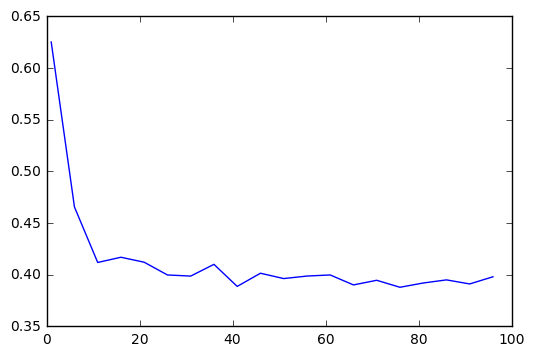

In [55]:
plt.title('Dev Data RMSE by Number of Estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('Dev Data RMSE')
plt.plot(n_estimators_list, results_list)
plt.show()

In [74]:
#Gridsearch CV with Adaboost
dt = DecisionTreeRegressor()

adb = AdaBoostRegressor(base_estimator = dt)

#parameter grid is a dictionary with features and values you want to check
parameter_grid = {'n_estimators': [10,15,20,25], 'learning_rate' : [1.5, 2.0, 2.5]}

#instantiate Grid search
searcher = GridSearchCV(adb, param_grid = parameter_grid, cv = 10, scoring = RMSE_scorer)
#searcher.fit(X_train_transformed_df, train_data['count'])

#get best parameters
searcher.best_params_

#note the best parameters are 21 estimators and a learning rate of 1.5

{'learning_rate': 1.5, 'n_estimators': 20}

In [24]:
#instantiate adaboost and decision tree regressors
dt = DecisionTreeRegressor()

ab = AdaBoostRegressor(n_estimators = 20, learning_rate = 1.5, base_estimator = dt)

#fit the classifier for casual rentals
ab.fit(X_train_transformed_df, train_data['count'])

#predict the training data and testing data
preds_train = ab.predict(X_train_transformed_df)
preds_dev = ab.predict(X_dev_transformed_df)
preds_test = ab.predict(X_test_transformed_df)

#actual
actual_train = train_data['count']
actual_dev = dev_data['count']

#Get RMSE for train and dev data
RMSE_train = get_RMSE(actual_values = actual_train, predicted_values = preds_train)
print "Train Data Root Mean Squared Error: " + str(RMSE_train)

RMSE_dev = get_RMSE(actual_values = actual_dev, predicted_values = preds_dev)
print "dev Data Root Mean Squared Error: " + str(RMSE_dev)

Train Data Root Mean Squared Error: 0.224243182366
dev Data Root Mean Squared Error: 0.440611660877


### Adaboost - Split into Late Night and Not

Helper function to split data into late night / day time

In [244]:
test_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,prog_age,hour
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,19.000000,0
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,19.041667,1
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,19.083333,2
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,19.125000,3
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,19.166667,4


In [245]:
def late_day_split(data_df, beg_late_night = 17, end_late_night = 4):
    late_night_df = data_df.loc[(data_df.hour <= end_late_night) | (data_df.hour >= beg_late_night), :]
    day_df = data_df.loc[(data_df.hour > end_late_night) & (data_df.hour < beg_late_night), :]
    return late_night_df, day_df

In [246]:
#Why does the late / day split leave out a bunch of observations from the test data?
#there are a number of rows missing hour in the test data
test_data.loc[:, 'hour'] = test_data.loc[:, 'hour'].astype(float)

print test_data.shape
print late_night_test.shape
print day_test.shape

test_data.describe()
test_data.head()


(6493, 11)
(780, 11)
(824, 11)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,prog_age,hour
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,19.000000,0.0
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,19.041667,1.0
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,19.083333,2.0
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,19.125000,3.0
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,19.166667,4.0


In [119]:
#convert hour back to numerical
train_data.loc[:, 'hour'] = train_data.loc[:, 'hour'].astype(float)
dev_data.loc[:, 'hour'] = dev_data.loc[:, 'hour'].astype(float)
test_data.loc[:, 'hour'] = test_data.loc[:, 'hour'].astype(float)


#first, split into late night and not
late_night_train, day_train = late_day_split(train_data)
late_night_dev, day_dev = late_day_split(dev_data)
late_night_test, day_test = late_day_split(test_data)

#From error analysis below, worst errors for late night seem to be concentrated at high program age. Try taking square root of program age as regularization.
late_night_train['prog_age'] = late_night_train['prog_age'] ** .5
late_night_dev['prog_age'] = late_night_dev['prog_age'] ** .5
late_night_test['prog_age'] = late_night_test['prog_age'] ** .5


#Transform each of the late night and day datasets
late_night_train_transformed = fu.fit_transform(late_night_train)
late_night_train_transformed_df = pd.DataFrame(late_night_train_transformed)

late_night_dev_transformed = fu.transform(late_night_dev)
late_night_dev_transformed_df = pd.DataFrame(late_night_dev_transformed)

late_night_test_transformed = fu.transform(late_night_test)
late_night_test_transformed_df = pd.DataFrame(late_night_test_transformed)


day_train_transformed = fu.fit_transform(day_train)
day_train_transformed_df = pd.DataFrame(day_train_transformed)

day_dev_transformed = fu.transform(day_dev)
day_dev_transformed_df = pd.DataFrame(day_dev_transformed)

day_test_transformed = fu.transform(day_test)
day_test_transformed_df = pd.DataFrame(day_test_transformed)

/Users/nwchen24/anaconda/envs/Machine_learning_python2/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/nwchen24/anaconda/envs/Machine_learning_python2/lib/python2.7/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/nwchen24/anaconda/envs/Machine_learning_python2/lib/python2.7/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

In [120]:
#Next, train a separate classifier for late night and not late night
#instantiate the late and day regressors

#These models perform exceptionally poorly on the dev data for late night
ab_late = AdaBoostRegressor(n_estimators = 10, learning_rate = 1.5, base_estimator = dt)
dt_late = RandomForestRegressor(n_estimators = 200, max_depth = 30)

ab_day = AdaBoostRegressor(n_estimators = 20, learning_rate = 1.5, base_estimator = dt)

#fit the classifier for casual rentals
ab_late.fit(late_night_train_transformed_df, late_night_train['count'])
ab_day.fit(day_train_transformed_df, day_train['count'])

#predict the training and dev data
preds_late_train = ab_late.predict(late_night_train_transformed_df)
preds_late_dev = ab_late.predict(late_night_dev_transformed_df)

preds_day_train = ab_day.predict(day_train_transformed_df)
preds_day_dev = ab_day.predict(day_dev_transformed_df)


In [121]:
#Get RMSE for train and dev data
RMSE_train_late = get_RMSE(actual_values = late_night_train['count'], predicted_values = preds_late_train)
print "LATE Train Data Root Mean Squared Error: " + str(RMSE_train_late)

RMSE_dev_late = get_RMSE(actual_values = late_night_dev['count'], predicted_values = preds_late_dev)
print "LATE Dev Data Root Mean Squared Error: " + str(RMSE_dev_late)

print 

RMSE_train_day = get_RMSE(actual_values = day_train['count'], predicted_values = preds_day_train)
print "DAY Train Data Root Mean Squared Error: " + str(RMSE_train_day)

RMSE_dev_day = get_RMSE(actual_values = day_dev['count'], predicted_values = preds_day_dev)
print "DAY Dev Data Root Mean Squared Error: " + str(RMSE_dev_day)

LATE Train Data Root Mean Squared Error: 0.220135836109
LATE Dev Data Root Mean Squared Error: 0.419169535853

DAY Train Data Root Mean Squared Error: 0.161100464915
DAY Dev Data Root Mean Squared Error: 0.352056499236


In [122]:
train_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,prog_age,hour,weather_descriptions,season_str
0,2012-12-09 17:00:00,4,0,0,3,14.76,17.425,93,8.9981,20,209,229,708.708333,17.0,Poor Weather,Winter
1,2011-06-19 00:00:00,2,0,0,1,28.70,32.575,65,0.0000,18,71,89,169.000000,0.0,Nice Weather,Summer
2,2012-05-10 19:00:00,2,0,1,1,22.14,25.760,37,23.9994,84,469,553,495.791667,19.0,Nice Weather,Summer
3,2011-12-06 08:00:00,4,0,1,2,18.86,22.725,94,12.9980,13,401,414,339.333333,8.0,OK Weather,Winter
4,2011-04-17 08:00:00,2,0,0,1,15.58,19.695,46,26.0027,7,36,43,106.333333,8.0,Nice Weather,Summer


#### Error Analysis

In [123]:
#Predictions with the largest absolute error
late_dev_errors = preds_late_dev - np.array(late_night_dev['count'])

#merge train errors with training data
dev_errors_df = late_night_dev.copy()

dev_errors_df['raw_error'] = late_dev_errors
dev_errors_df['abs_error'] = abs(dev_errors_df.raw_error)
dev_errors_df['pred_count'] = preds_late_dev

#rank observations by absolute value of error
dev_errors_df['abs_error_rank'] = dev_errors_df.abs_error.rank(ascending = False)
dev_errors_df['hour'] = dev_errors_df.hour.astype(float)


#get the worst ~20% of errors
dev_errors_df = dev_errors_df.sort_values(by = 'abs_error_rank', axis = 0)
dev_errors_df = dev_errors_df.reset_index(drop = True)
worst_errors = dev_errors_df.loc[:300,]
OK_predictions = dev_errors_df.loc[300:,]

worst_errors.describe()
#dev_errors_df.head()

worst_errors.head(n=25)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,prog_age,hour,raw_error,abs_error,pred_count,abs_error_rank
0,2012-07-18 17:00:00,3,0,1,1,30.34,34.850,70,16.9979,35,335,370,23.763593,17.0,438.0,438.0,808.0,1.0
1,2012-10-11 19:00:00,4,0,1,1,18.04,21.970,51,8.9981,81,662,743,25.491011,19.0,-310.0,310.0,433.0,2.0
2,2011-05-11 18:00:00,2,0,1,1,25.42,31.060,50,19.9995,40,234,274,11.434597,18.0,264.0,264.0,538.0,3.0
3,2012-03-16 17:00:00,1,0,1,3,19.68,23.485,82,6.0032,23,235,258,20.993054,17.0,230.0,230.0,488.0,4.0
4,2012-07-10 19:00:00,3,0,1,3,28.70,33.335,74,15.0013,55,359,414,23.596433,19.0,219.0,219.0,633.0,5.0
5,2012-07-06 18:00:00,3,0,1,1,36.90,40.150,33,16.9979,106,454,560,23.510636,18.0,212.0,212.0,772.0,6.0
6,2012-07-08 18:00:00,3,0,0,1,31.98,37.120,62,7.0015,54,199,253,23.553131,18.0,210.0,210.0,463.0,7.0
7,2012-07-06 17:00:00,3,0,1,1,37.72,40.910,29,0.0000,90,486,576,23.509750,17.0,194.0,194.0,770.0,8.0
8,2012-11-12 18:00:00,4,1,0,1,21.32,25.000,72,8.9981,65,486,551,26.110343,18.0,-192.0,192.0,359.0,9.0
9,2011-10-11 18:00:00,4,0,1,2,24.60,28.790,78,15.0013,46,493,539,16.844881,18.0,-184.0,184.0,355.0,10.5


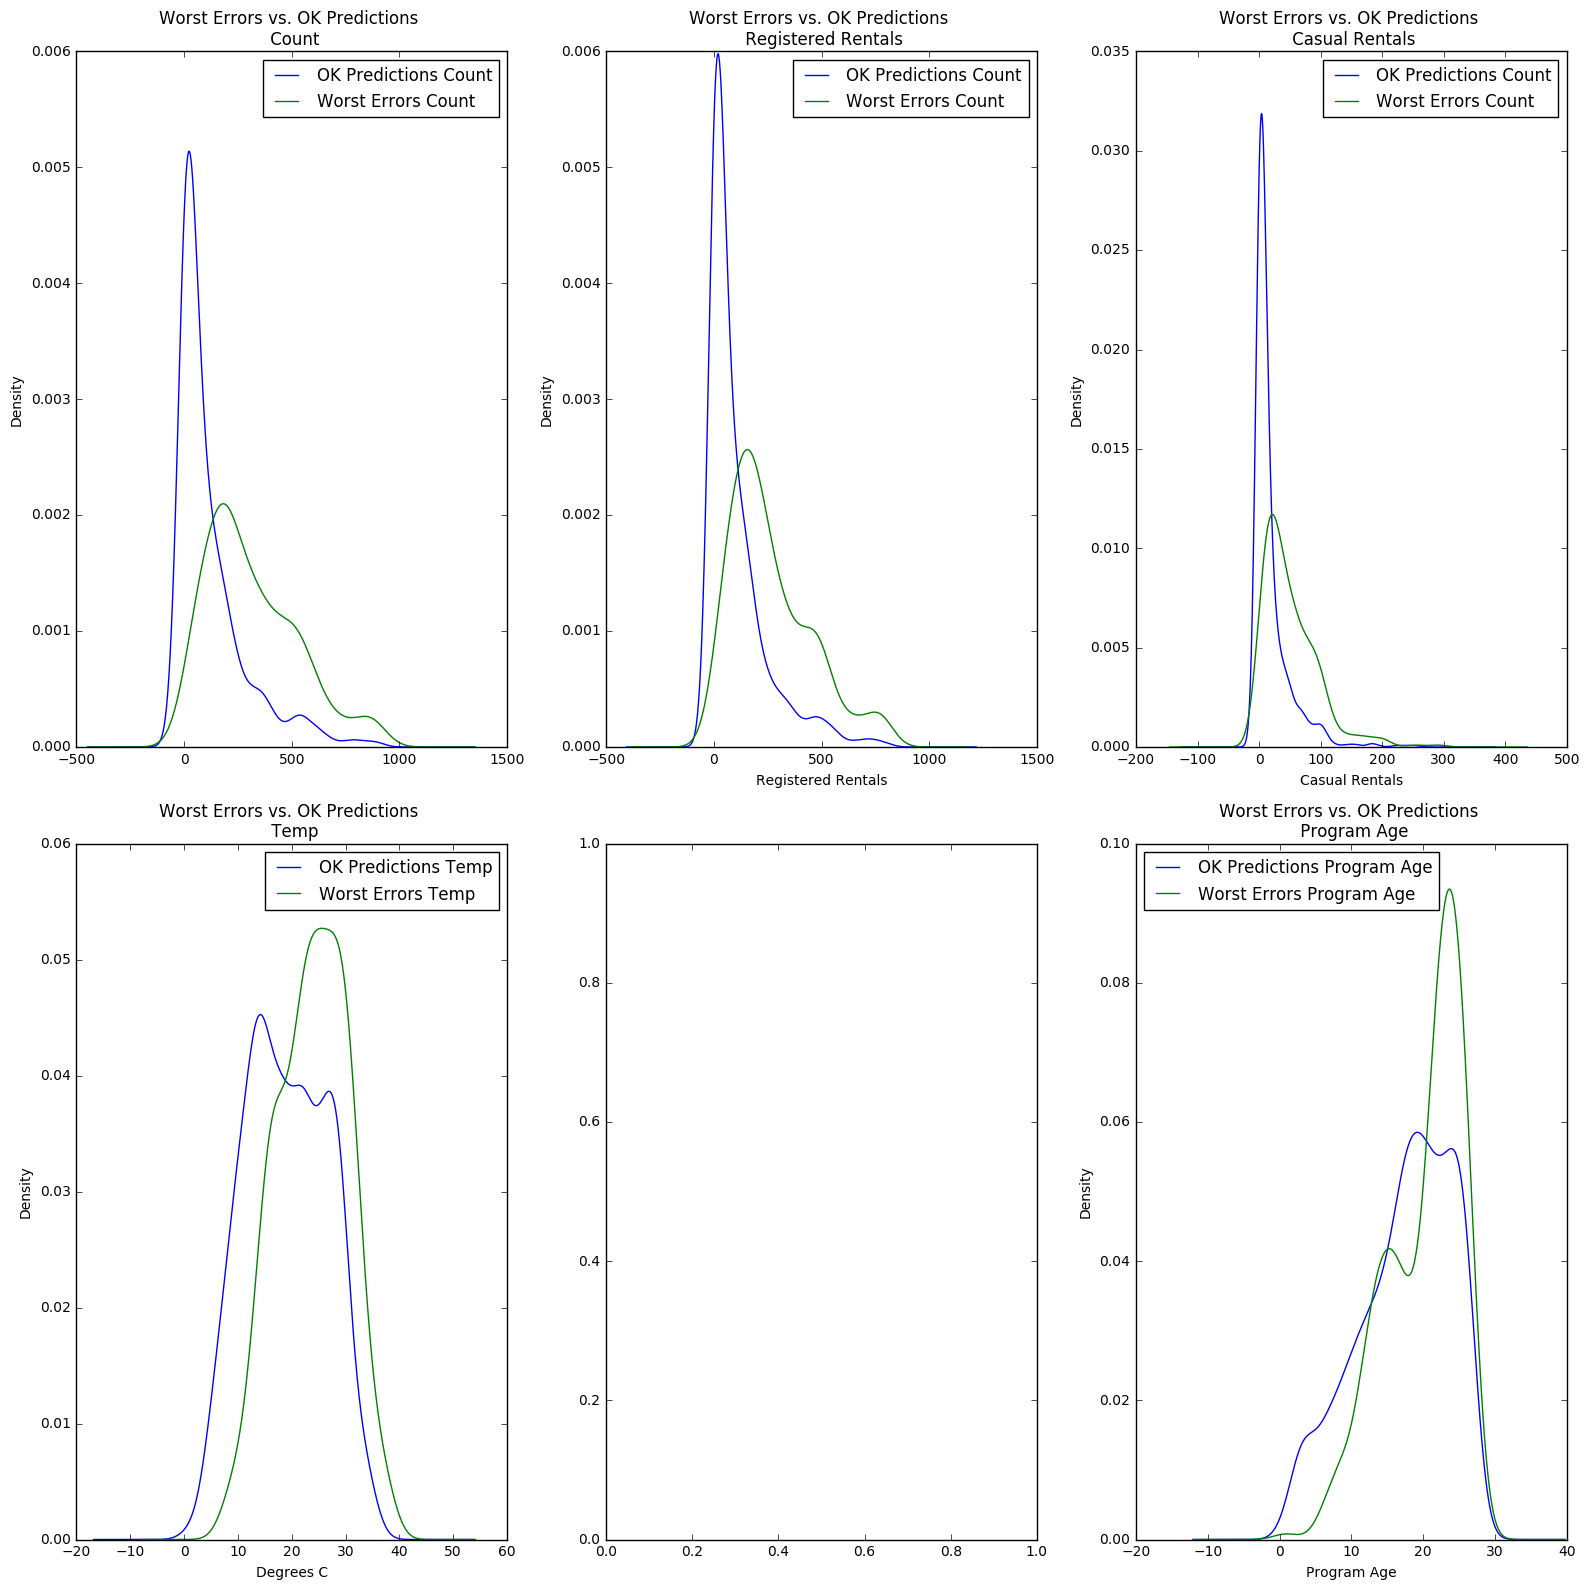

In [124]:
#Look at various features in the worst errors compared to the overall dataset

fig, axes = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False, figsize = (16,16))


#count
#The model does not seem to do well with high rental days - there is a higher concentration of higher rentals
#in the worst errors than in the other predictions
ax = fig.add_subplot(2,3,1)
plt.subplot(2,3,1)
OK_predictions['count'].plot(kind = 'density', label = 'OK Predictions Count')
worst_errors['count'].plot(kind = 'density', label = 'Worst Errors Count')
plt.legend(loc=1, ncol=1)
plt.title('Worst Errors vs. OK Predictions \n Count')



#registered
#The model does not seem to do well with high rental days - there is a higher concentration of higher rentals
#in the worst errors than in the other predictions
ax = fig.add_subplot(2,3,2)
plt.subplot(2,3,2)
OK_predictions['registered'].plot(kind = 'density', label = 'OK Predictions Count')
worst_errors['registered'].plot(kind = 'density', label = 'Worst Errors Count')
plt.legend(loc=1, ncol=1)
plt.xlabel('Registered Rentals')
plt.title('Worst Errors vs. OK Predictions \n Registered Rentals')


#casual
#The model seems to do pretty well with casual rentals - the distribution of casual rentals
#in the worst predictions and the ok predictions look similar
ax = fig.add_subplot(2,3,3)
plt.subplot(2,3,3)
OK_predictions['casual'].plot(kind = 'density', label = 'OK Predictions Count')
worst_errors['casual'].plot(kind = 'density', label = 'Worst Errors Count')
plt.legend(loc=1, ncol=1)
plt.xlabel('Casual Rentals')
plt.title('Worst Errors vs. OK Predictions \n Casual Rentals')



#Temp
ax = fig.add_subplot(2,3,4)
plt.subplot(2,3,4)
OK_predictions['temp'].plot(kind = 'density', label = 'OK Predictions Temp')
worst_errors['temp'].plot(kind = 'density', label = 'Worst Errors Temp')
plt.legend(loc=1, ncol=1)
plt.xlabel('Degrees C')
plt.title('Worst Errors vs. OK Predictions \n Temp')


#Hour
#ax = fig.add_subplot(2,3,5)
#plt.subplot(2,3,5)
#OK_predictions['hour'].plot(kind = 'density', label = 'OK Predictions Hour')
#worst_errors['hour'].plot(kind = 'density', label = 'Worst Errors Hour')
#plt.legend(loc=1, ncol=1)
#plt.xlabel('Hour')
#plt.title('Worst Errors vs. OK Predictions \n Hour')



#Program age
ax = fig.add_subplot(2,3,6)
plt.subplot(2,3,6)
OK_predictions['prog_age'].plot(kind = 'density', label = 'OK Predictions Program Age')
worst_errors['prog_age'].plot(kind = 'density', label = 'Worst Errors Program Age')
plt.legend(loc=2, ncol=1)
plt.xlabel('Program Age')
plt.title('Worst Errors vs. OK Predictions \n Program Age')


plt.tight_layout()
    
plt.show()




### Predict Test Dataset

In [132]:
#predict
preds_late_test = ab_late.predict(late_night_test_transformed_df)
preds_day_test = ab_day.predict(day_test_transformed_df)

#convert test predictions to DataFrame
preds_late_test_df = pd.DataFrame(preds_late_test, columns = ['count'])
preds_day_test_df = pd.DataFrame(preds_day_test, columns = ['count'])

#reset indices so can append date time
late_night_test.reset_index(drop = True, inplace = True)
day_test.reset_index(drop = True, inplace = True)

#add column with datetime
preds_late_test_df['datetime'] = late_night_test['datetime']
preds_day_test_df['datetime'] = day_test['datetime']

#stack
preds_test_df = preds_day_test_df.copy()

preds_test_df = preds_test_df.append(preds_late_test_df)



(824, 2)
(1604, 2)


In [133]:
#export testing data results

#first change the working directory
os.chdir("/Users/nwchen24/Desktop/UC_Berkeley/machine_learning/final_project_github_repo/w207_kaggleproject/NC_work/Output/")

#re-order columns
preds_test_df = preds_test_df[['datetime', 'count']]

#export to CSV
preds_test_df.to_csv('NC_submission_2.csv', index = False)

preds_test_df.head()

,datetime,count
0,2011-01-20 09:00:00,122.0
1,2011-01-20 15:00:00,96.0
2,2011-01-21 07:00:00,210.0
3,2011-01-21 08:00:00,94.0
4,2011-01-21 09:00:00,49.0
